In [2]:
import mitsuba as mi
import drjit as dr
import numpy as np
from sionna.rt import load_scene, Transmitter, Receiver, Camera
import matplotlib.pyplot as plt

In [3]:
mi.set_variant("llvm_ad_mono_polarized")

In [4]:
import sionna.rt as rt

In [5]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\downtown_chicago\DowntownChicago1KM.xml"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)

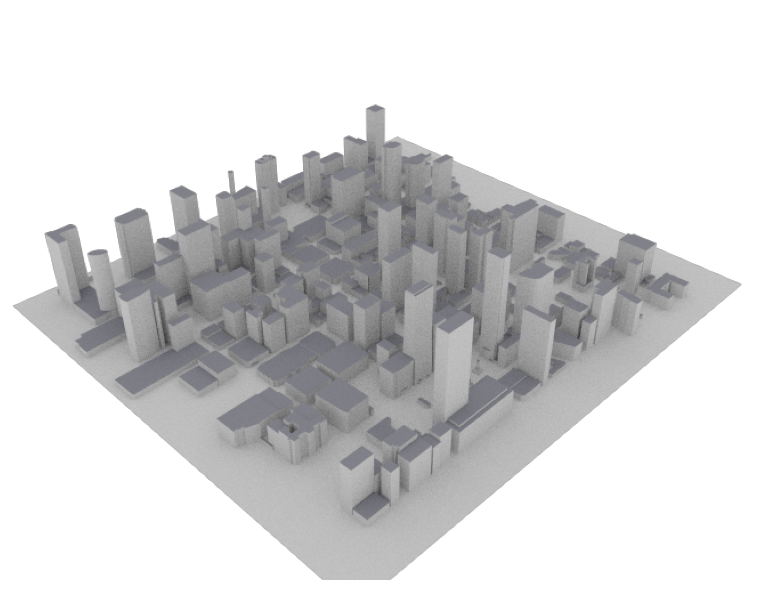

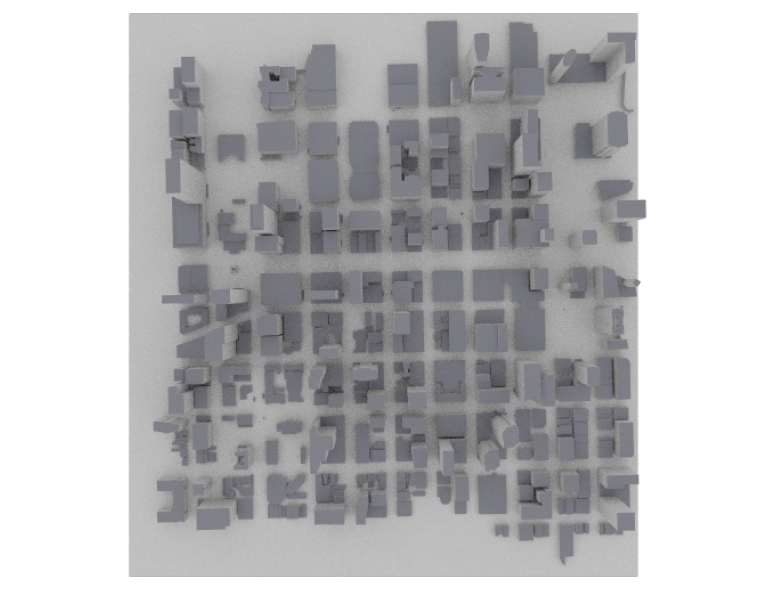

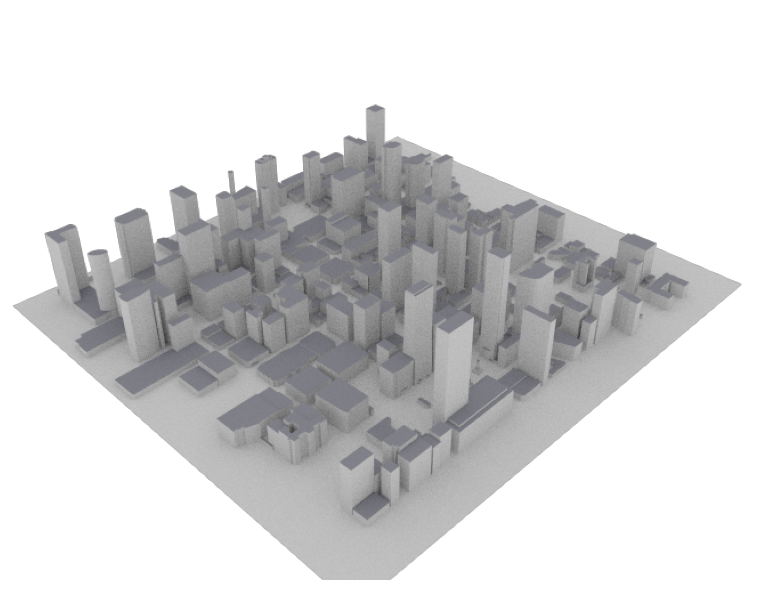

In [6]:
overhead = Camera(position=(0.0, 0.0, 2000.0))
overhead.look_at((0.0,0.0,0.0))
scene.render(camera=overhead)

isometric = Camera(position=(1200.0, 1200.0, 1200.0))
isometric.look_at((0.0,0.0,0.0))
scene.render(camera=isometric)

# Camera on render should be Z up, Y forwards!

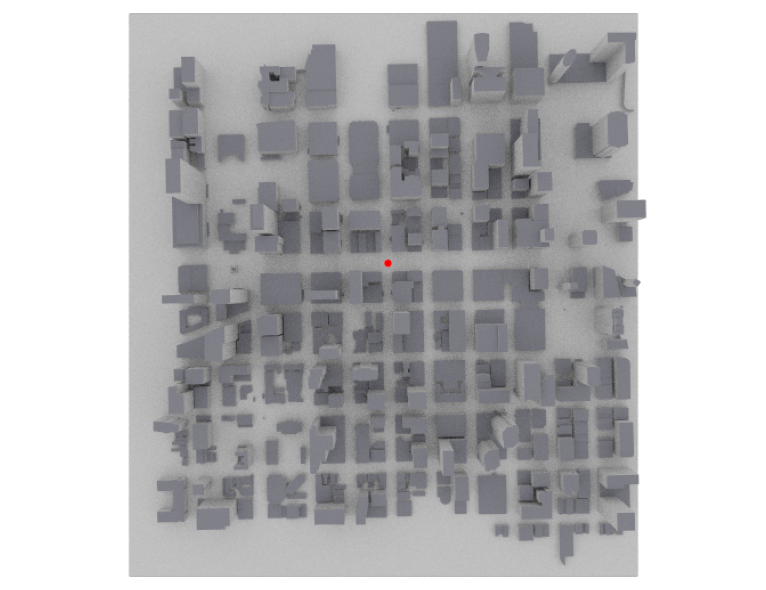

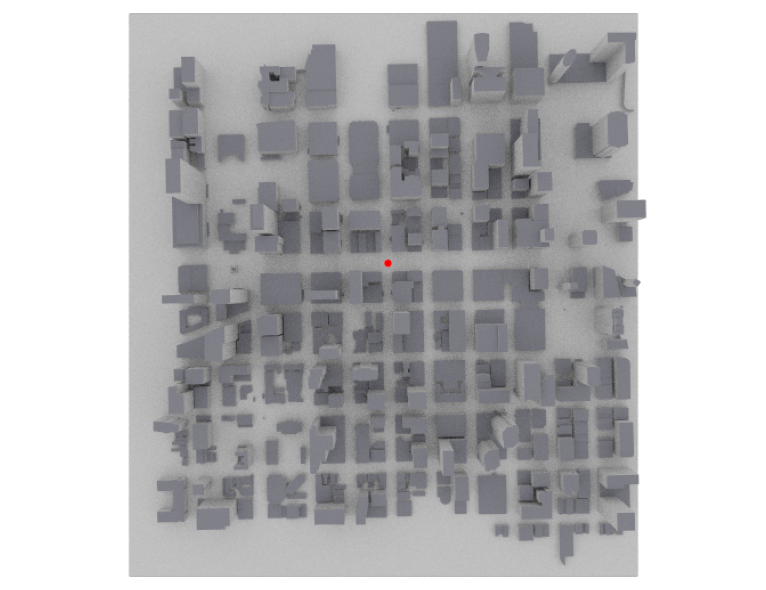

In [7]:
# Set up antenna arrays
scene.tx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# Add Transmitter
tx = Transmitter(name="Tx1", position=[70,-10,10], color=[1.0, 0.0, 0.0])
scene.add(tx)
# Visualize scene with transmitter and receivers in place
cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)

Total receivers: 1600


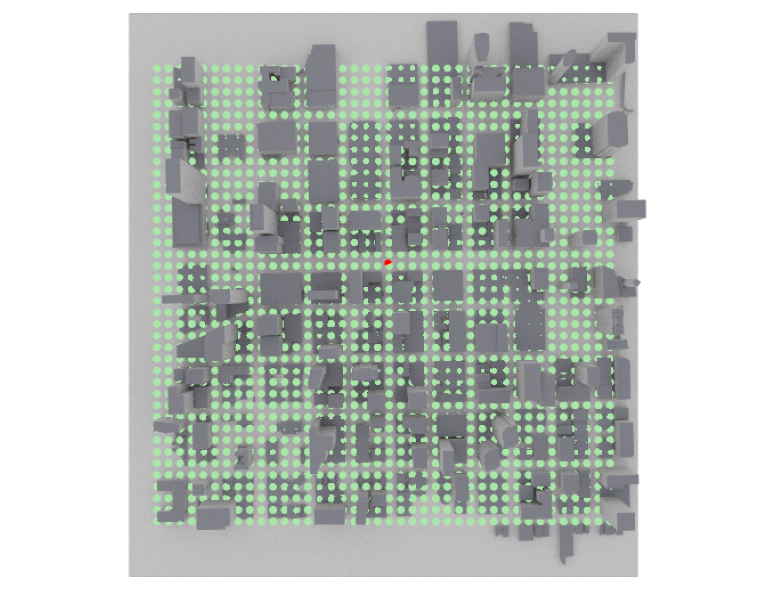

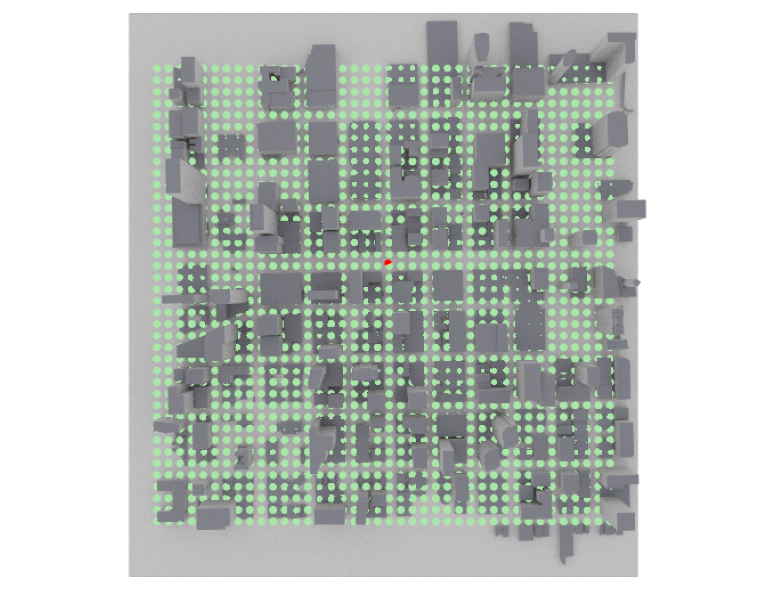

In [8]:
x_min, x_max = -500, 500
y_min, y_max = -500, 500
z_height = 10

num_x = 40
num_y = 40

x_coords = np.linspace(x_min, x_max, num_x)
y_coords = np.linspace(y_min, y_max, num_y)
X, Y = np.meshgrid(x_coords, y_coords)

x_flat = X.flatten()
y_flat = Y.flatten()

print(f"Total receivers: {len(x_flat)}")

# %%
# Add all receivers to scene
for i, (x, y) in enumerate(zip(x_flat, y_flat)):
    rx = Receiver(name=f"Rx_{i}", position=[float(x), float(y), float(z_height)], color=[0.4, 0.8, 0.4])
    scene.add(rx)


# Visualize scene with transmitter and receivers in place
cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)


In [9]:
# Compute paths for all receivers
path_solver = rt.PathSolver()

power_grid = np.zeros((num_y, num_x))
path_count_grid = np.zeros((num_y, num_x))

# Compute paths once for all receivers
paths = path_solver(scene, max_depth=3)

# Get channel impulse response
a_list, tau_list = paths.cir()
a = np.array(a_list)
tau = np.array(tau_list)

print(f"CIR shape: {a.shape}")
print(f"Expected: [batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]")

# %%
# Process each receiver from the CIR
for i in range(len(x_flat)):
    # Extract CIR for receiver i
    # Shape should be [1, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, ...]
    a_rx = a[0, i, 0, 0, 0, :, :]  # adjust indexing based on actual shape
    
    # Total received power
    power_linear = np.sum(np.abs(a_rx)**2)
    
    # Store in grid
    row = i // num_x
    col = i % num_x
    power_grid[row, col] = power_linear
    path_count_grid[row, col] = a_rx.shape[0]  # number of paths
    
    if i % 50 == 0:
        print(f"Processed {i}/{len(x_flat)} receivers")

# Convert to dB
power_grid_db = 10 * np.log10(power_grid + 1e-12)

print(f"\nPower range: {power_grid_db.min():.2f} to {power_grid_db.max():.2f} dB")

CIR shape: (2, 1600, 1, 1, 1, 15, 1)
Expected: [batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
Processed 0/1600 receivers
Processed 50/1600 receivers
Processed 100/1600 receivers
Processed 150/1600 receivers
Processed 200/1600 receivers
Processed 250/1600 receivers
Processed 300/1600 receivers
Processed 350/1600 receivers
Processed 400/1600 receivers
Processed 450/1600 receivers
Processed 500/1600 receivers
Processed 550/1600 receivers
Processed 600/1600 receivers
Processed 650/1600 receivers
Processed 700/1600 receivers
Processed 750/1600 receivers
Processed 800/1600 receivers
Processed 850/1600 receivers
Processed 900/1600 receivers
Processed 950/1600 receivers
Processed 1000/1600 receivers
Processed 1050/1600 receivers
Processed 1100/1600 receivers
Processed 1150/1600 receivers
Processed 1200/1600 receivers
Processed 1250/1600 receivers
Processed 1300/1600 receivers
Processed 1350/1600 receivers
Processed 1400/1600 receivers
Processed 1450/1600 receivers
P

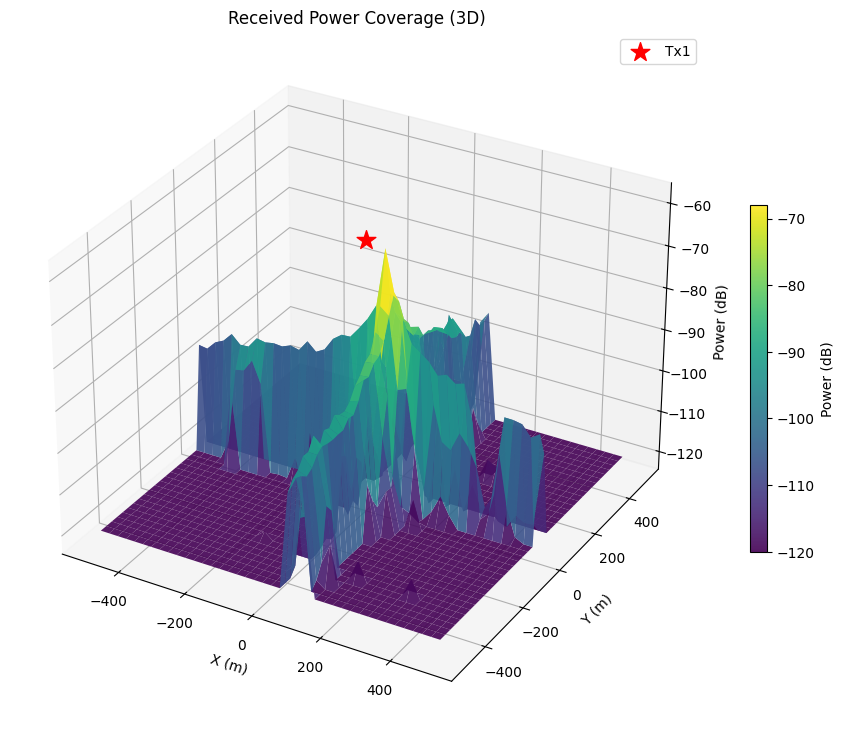

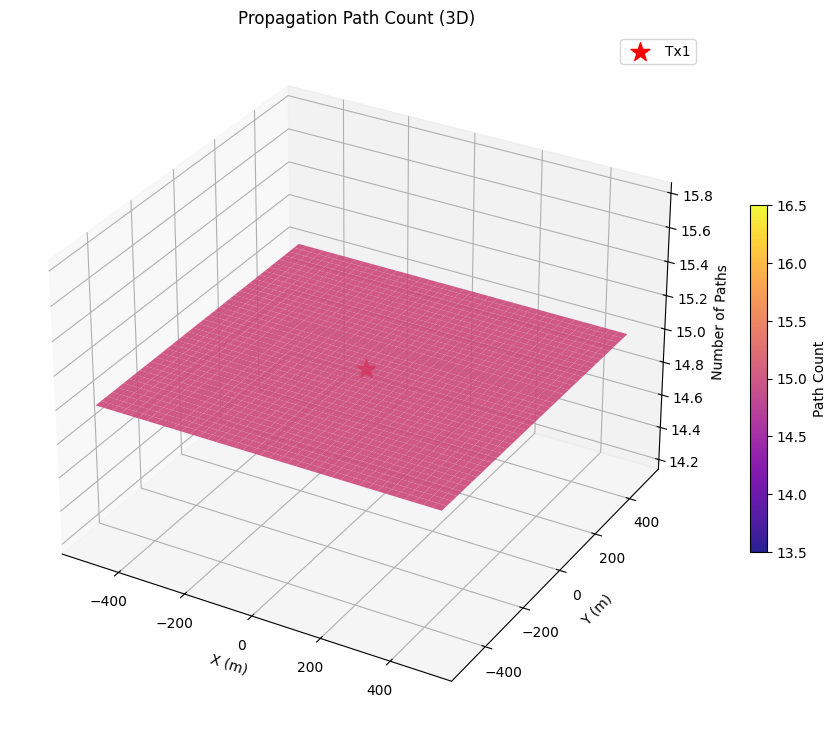

In [10]:
# 3D Surface plot of received power
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, power_grid_db, cmap='viridis', 
                       edgecolor='none', alpha=0.9)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Power (dB)')
ax.set_title('Received Power Coverage (3D)')

# Add transmitter location
ax.scatter([0], [0], [power_grid_db.max()], color='red', s=200, marker='*', label='Tx1')

fig.colorbar(surf, ax=ax, shrink=0.5, label='Power (dB)')
ax.legend()
plt.show()

# %%
# 3D Surface plot of path count
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, path_count_grid, cmap='plasma', 
                       edgecolor='none', alpha=0.9)

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Number of Paths')
ax.set_title('Propagation Path Count (3D)')

# Add transmitter location
ax.scatter([0], [0], [path_count_grid.max()], color='red', s=200, marker='*', label='Tx1')

fig.colorbar(surf, ax=ax, shrink=0.5, label='Path Count')
ax.legend()
plt.show()
